In [1]:
import sys
sys.path.append('../..')

In [2]:
import torch

if torch.cuda.is_available():
    device = 'cuda'
if torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

## Footprint to pressure dataset

In [3]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image, ImageOps

import torch
from torch.utils.data import Dataset
from torchvision import transforms

from src.tool.registry import DATASET_REGISTRY

# @DATASET_REGISTRY.register()
class Footprint2Pressure(Dataset):
    def __init__(
            self: str,
            device: str,
            footprint_wrap_folder: str = 'data/processed/footprint-wrap',
            pedar_dynamic_path: str = 'data/processed/pedar_dynamic.pkl',
            l_mask_path: str = 'data/processed/left_foot_mask.png',
            sense_range: float = 600,
            stack_range: int = 50,
            img_size: int = 10,
            dtype = torch.float32,
            ):
        self.device = device

        self.footprint_wrap_folder = Path(footprint_wrap_folder)
        self.pedar_dynamic = pd.read_pickle(pedar_dynamic_path)
        self.dtype = dtype
        self.sense_range = sense_range
        self.stack_range = stack_range
        self.img_size = img_size

        self.load_foot_mask(l_mask_path)
        
        # youngs modulus (MPa)
        self.material_youngs = {
            'Poron': 0.33,
            'PElite': 1.11,
            'Lunalight': 5.88,
            'Lunanastik': 0.71,
            'BF': 0.00,
        }

        # get index
        self.index = []

        for material, subject in self.pedar_dynamic.index:
            if os.path.isfile(self.footprint_wrap_folder / f'{subject}-L.jpg'):
                self.index.append((material, subject))

    def load_foot_mask(self, l_mask_path: str):
        # load foot masks
        l_img = Image.open(l_mask_path)
        r_img = ImageOps.mirror(l_img)

        self.l_mask = np.array(l_img).astype(np.float64)
        self.r_mask = np.array(r_img).astype(np.float64)

        # detect pixels of area no.1~197 and store the corresponding indexes
        self.l_index = {}
        self.r_index = {}

        for n in range(0, 99):
            self.l_index[n] = np.where(self.l_mask == n + 1)
            self.r_index[n + 99] = np.where(self.r_mask == n + 1)

        # index grids for slicing footprint image as sensor stacks
        range_half = int(self.stack_range / 2)

        self.x_grid = {'L': [], 'R': []}
        self.y_grid = {'L': [], 'R': []}

        for sensor in range(99):
            x_center, y_center = int(self.l_index[sensor][0].mean()), int(self.l_index[sensor][1].mean())
            xs = np.arange(x_center - range_half, x_center + range_half)
            ys = np.arange(y_center - range_half, y_center + range_half)
            xg, yg = np.meshgrid(xs, ys, indexing='ij')
            self.x_grid['L'].append(xg)
            self.y_grid['L'].append(yg)

        for sensor in range(99, 198):
            x_center, y_center = int(self.r_index[sensor][0].mean()), int(self.r_index[sensor][1].mean())
            xs = np.arange(x_center - range_half, x_center + range_half)
            ys = np.arange(y_center - range_half, y_center + range_half)
            xg, yg = np.meshgrid(xs, ys, indexing='ij')
            self.x_grid['R'].append(xg)
            self.y_grid['R'].append(yg)

    def __len__(self):
        return len(self.index)
    
    def __getitem__(self, index: int) -> tuple:
        # get subject
        material = self.index[index][0]
        subject = self.index[index][1]
        
        # weight blends young modulus & pedar arrays
        arr_pedar = self.pedar_dynamic.loc[material, subject].values / self.sense_range
        pedar_t = torch.tensor(arr_pedar, dtype=self.dtype)

        # load and stack left & right footprint images as (2, size, size) tensor
        def get_img_stack(foot: str):
            img = Image.open(self.footprint_wrap_folder / f'{subject}-{foot}.jpg')
            img_arr = np.mean(1 - np.array(img).astype(np.float64) / 255, axis=-1)
            return torch.tensor(img_arr, dtype=self.dtype).unsqueeze(0)
        
        img_l = get_img_stack('L')
        img_r = get_img_stack('R')
        img_stack = torch.concat([img_l, img_r])

        # remember to move data to device!
        return (img_stack.to(self.device), material), pedar_t.to(self.device)

In [4]:
self = Footprint2Pressure(
    device = device,
    footprint_wrap_folder = '../../data/processed/footprint-wrap',
    pedar_dynamic_path = '../../data/processed/pedar_dynamic.pkl',
    l_mask_path = '../../data/processed/left_foot_mask.png',
)
len(self)

250

In [5]:
(img_stack, material), pedar_t = self.__getitem__(3)
material

'BF'

torch.Size([2, 816, 303])


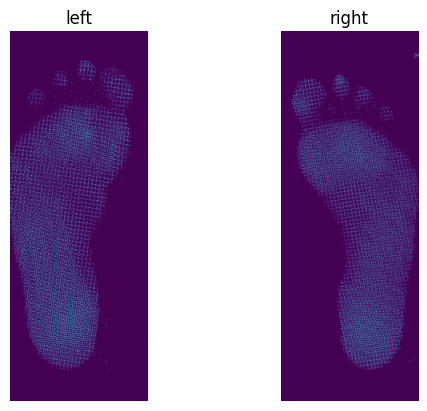

In [6]:
from matplotlib import pyplot as plt

print(img_stack.shape)

fig, axs = plt.subplots(1, 2)

axs[0].imshow(img_stack[0].cpu().detach().numpy())
axs[0].set_title('left')
axs[0].axis('off')

axs[1].imshow(img_stack[1].cpu().detach().numpy())
axs[1].set_title('right')
axs[1].axis('off')

plt.show()

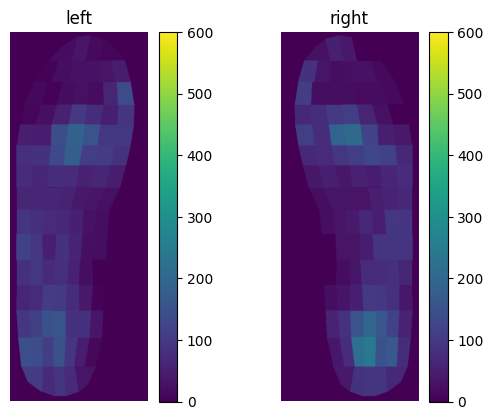

In [7]:
from src.tool import visual

visual.draw_heatmap(pedar_t.cpu().detach().numpy() * 600, '../../data/processed/left_foot_mask.png')

## Material data augmentation via blending

In [8]:
# @DATASET_REGISTRY.register()
class Footprint2Pressure_Blend(Footprint2Pressure):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        # youngs modulus (MPa)
        self.material_youngs = {
            'Poron': 0.33,
            'PElite': 1.11,
            'Lunalight': 5.88,
            'Lunanastik': 0.71,
            'BF': 0.00,
        }

        # get index
        self.index = []

        for subject in self.pedar_dynamic.index.get_level_values(1).drop_duplicates():
            if os.path.isfile(self.footprint_wrap_folder / f'{subject}-L.jpg'):
                self.index.append(subject)
    
    def __getitem__(self, index: int, blend_weight: np.array = None) -> tuple:
        if blend_weight is None:
            blend_weight = np.random.rand(5)
            blend_weight = blend_weight / blend_weight.sum()

        # get subject
        subject = self.index[index]
        
        # weight blends young modulus & pedar arrays
        arr_pedar = self.pedar_dynamic.loc[:, subject, :].values / self.sense_range
        blend_pedar = torch.tensor(
            (arr_pedar * np.expand_dims(blend_weight, axis=-1)).sum(axis=0),
            dtype=self.dtype,
            )
        blend_young = torch.tensor(
            (np.array(list(self.material_youngs.values())) * blend_weight).sum(),
            dtype=self.dtype,
            )

        # load and stack left & right footprint images as (2, size, size) tensor
        def get_img_stack(foot: str):
            img = Image.open(self.footprint_wrap_folder / f'{subject}-{foot}.jpg')
            img_arr = np.mean(1 - np.array(img).astype(np.float64) / 255, axis=-1)
            return torch.tensor(img_arr, dtype=self.dtype).unsqueeze(0)
        
        img_l = get_img_stack('L')
        img_r = get_img_stack('R')
        img_stack = torch.concat([img_l, img_r])

        # remember to move data to device!
        return (img_stack.to(self.device), blend_young.to(self.device)), blend_pedar.to(self.device)

In [9]:
self = Footprint2Pressure_Blend(
    device = device,
    footprint_wrap_folder = '../../data/processed/footprint-wrap',
    pedar_dynamic_path = '../../data/processed/pedar_dynamic.pkl',
    l_mask_path = '../../data/processed/left_foot_mask.png',
)
len(self)

50

In [10]:
(img_stack, material), pedar_t = self.__getitem__(3)
material

tensor(1.2573, device='mps:0')

torch.Size([2, 816, 303])


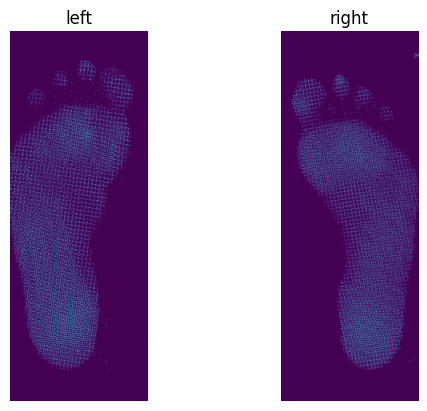

In [11]:
from matplotlib import pyplot as plt

print(img_stack.shape)

fig, axs = plt.subplots(1, 2)

axs[0].imshow(img_stack[0].cpu().detach().numpy())
axs[0].set_title('left')
axs[0].axis('off')

axs[1].imshow(img_stack[1].cpu().detach().numpy())
axs[1].set_title('right')
axs[1].axis('off')

plt.show()

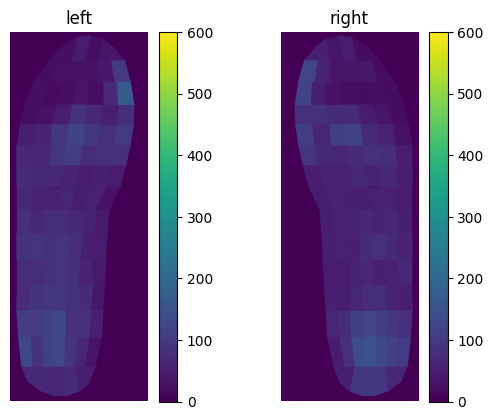

In [12]:
from src.tool import visual

visual.draw_heatmap(pedar_t.cpu().detach().numpy() * 600, '../../data/processed/left_foot_mask.png')

## Sensor slicing stacks

In [13]:
# @DATASET_REGISTRY.register()
class Footprint2Pressure_Blend_SensorStack(Footprint2Pressure_Blend):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def __getitem__(self, index: int, blend_weight: np.array = None) -> tuple:
        if blend_weight is None:
            blend_weight = np.random.rand(5)
            blend_weight = blend_weight / blend_weight.sum()

        # get subject
        subject = self.index[index]
        
        # weight blends young modulus & pedar arrays
        arr_pedar = self.pedar_dynamic.loc[:, subject, :].values / self.sense_range
        blend_pedar = torch.tensor(
            (arr_pedar * np.expand_dims(blend_weight, axis=-1)).sum(axis=0),
            dtype=self.dtype,
            )
        blend_young = torch.tensor(
            (np.array(list(self.material_youngs.values())) * blend_weight).sum(),
            dtype=self.dtype,
            )

        # load footprint image and slice as per-sensor stacks
        def get_img_stack(foot: str):
            img = Image.open(self.footprint_wrap_folder / f'{subject}-{foot}.jpg')
            img_arr = np.mean(1 - np.array(img).astype(np.float64) / 255, axis=-1)
            img_stack = img_arr[self.x_grid[foot], self.y_grid[foot]]
            img_stack = torch.tensor(img_stack, dtype=self.dtype)
            img_stack = transforms.Resize((self.img_size, self.img_size))(img_stack)
            return img_stack
        
        l_stack = get_img_stack('L')
        r_stack = get_img_stack('R')
        img_stack = torch.concat([l_stack, r_stack])

        # remember to move data to device!
        return (img_stack.to(self.device), blend_young.to(self.device)), blend_pedar.to(self.device)

In [14]:
self = Footprint2Pressure_Blend_SensorStack(
    device = device,
    footprint_wrap_folder = '../../data/processed/footprint-wrap',
    pedar_dynamic_path = '../../data/processed/pedar_dynamic.pkl',
    l_mask_path = '../../data/processed/left_foot_mask.png',
)
len(self)

50

In [15]:
(img_stack, material), pedar_t = self.__getitem__(3)
material

tensor(0.5251, device='mps:0')

torch.Size([198, 10, 10])


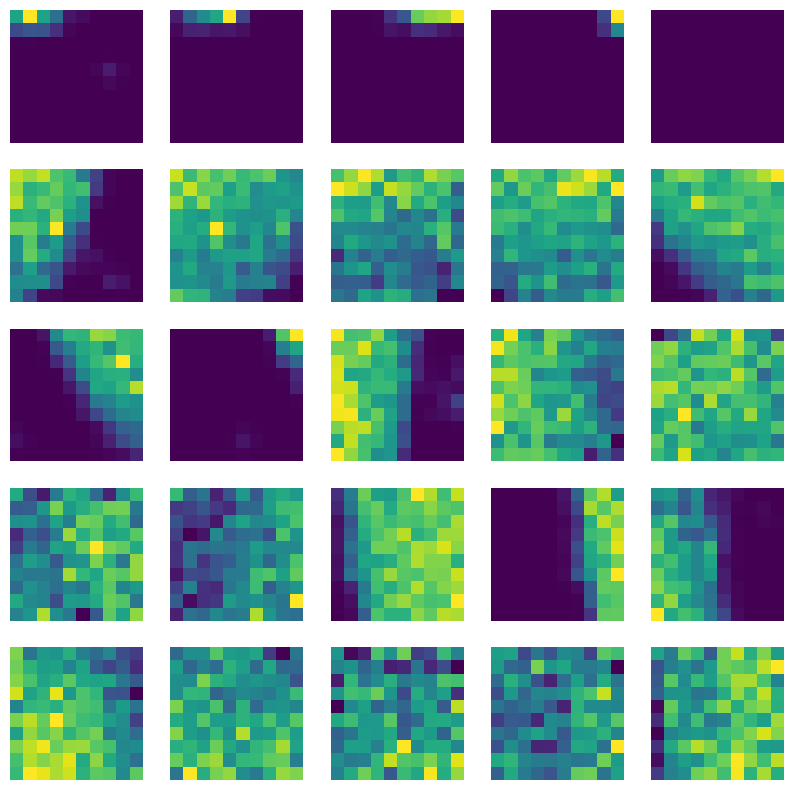

In [16]:
from matplotlib import pyplot as plt

print(img_stack.shape)

fig, axs = plt.subplots(5, 5, figsize=(10, 10))

for idx in range(5 * 5):
    axs[idx // 5][idx % 5].imshow(img_stack[idx].cpu().detach().numpy())
    axs[idx // 5][idx % 5].axis('off')

plt.show()